# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [51]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [52]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [53]:
print(newsgroups_test.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [4]:
def Q1(num_examples=5):
    ### STUDENT START ###
    #for number of examples passed as a parameter in the function
    for i in range(num_examples):
        #print example number
        print("Example "+str(i+1)+":\n"+
              #followed by the example lable
              "Label: " + newsgroups_train.target_names[newsgroups_train.target[i]] + 
              #followed by the actual text
             "\nText: " + newsgroups_train.data[i]+"\n"+
             "------------------------------------------------------------------------------")
    
    ### STUDENT END ###

Q1(5)

Example 1:
Label: comp.graphics
Text: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------------------------------------------------------------------
Example 2:
Label: talk.religion.misc
Text: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [3]:
def Q2():
    ### STUDENT START ###
    vctr = CountVectorizer()
    data = vctr.fit_transform(newsgroups_train.data)
    #number of examples is number of rows in the document matrix and vocab size is the number of "columns"
    num_examps,v_size = data.shape
    vocab = vctr.get_feature_names()
    print("Problem 1: ")
    print("A. The size of the vocab is "+str(v_size)+" words.")
    #now find average non-zero terms in each example
    #variable to count number of non-zero terms
    count = 0
    #for every row in the array
    for i in data:
        #find number of non-zero values ini each example and increment count variable
        count += i.nnz
    print("B. The average number of non-zero features in an example is "+ str(count/num_examps))
    #find the fraction by dividing the count by total number of elements in the data array, which we
    #can find by multiplying the array dimensions
    print("C. The fraction of the non-zero entries in the matrix is "+ 
         str(count/(num_examps*v_size)))
    print("D. The first and last features are "+vocab[0]+" and "+vocab[-1])
    print("\nProblem 2: ")
    #refit the model with a new vocabulary
    vctr2 = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    data2 = vctr2.fit_transform(newsgroups_train.data)
    #count non-zero features in new array
    count2 = 0
    for j in data2:
        count2 += j.nnz
    print("Vocabulary is size "+str(len(vctr2.get_feature_names())))
    print("A. The average numbers of non-zero features per example are: " + 
         str(count2/num_examps))
    print("\nProblem 3: ")
    #refit model for bi- and tri-grams then find length of 
    vctr3 = CountVectorizer(analyzer = 'char',ngram_range=(2,3))
    data3 = vctr3.fit_transform(newsgroups_train.data)
    vctr3.fit_transform(newsgroups_train.data)
    print("A. Vocab size for bi- and tri-grams is: "+
             str(len(vctr3.get_feature_names())))
    print("\nProblem 4:")
    #refit the model for unigram features
    vctr4 = CountVectorizer(analyzer = 'char',ngram_range=(1,1))
    #generate document matrix and turn it into numpy array
    data4 = vctr4.fit_transform(newsgroups_train.data).toarray()
    #turn vocab into a np.array
    vocab = np.array(vctr4.get_feature_names())
    #find bool matrix for all elements one or greater and multiply by one to indicate the simple presence of
    #a term in document
    #then
    #sum down columns to find total feature frequency count, then generate a boolen vector to ID features with
    #counts<10, and use that vector to prune vocab
    #then
    #find length of new vocab list and print it 
    print("A. Pruned vocabulary size is: "+
          str(vocab[((data4>=1)*1).sum(axis=0)>10].shape[0]))
    print("\nProblem 5:")
    #generate vocab for dev set
    vctr6 = CountVectorizer()
    vctr6.fit_transform(dev_data)
    #turn vocabs into dev sets then use set arithmetic to see what's in dev and not training
    v = set(vctr.get_feature_names())
    v5 = set(vctr6.get_feature_names())
    print("A. The fraction of words in the dev vocab that is missing from the training vocab is: " + 
    str(len(v5-v)/len(v5)))
    ### STUDENT END ###

Q2()

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Problem 1: 
A. The size of the vocab is 26879 words.
B. The average number of non-zero features in an example is 96.70599803343165
C. The fraction of the non-zero entries in the matrix is 0.0035978272269590263
D. The first and last features are 00 and zyxel

Problem 2: 
Vocabulary is size 4
A. The average numbers of non-zero features per example are: 0.26843657817109146

Problem 3: 
A. Vocab size for bi- and tri-grams is: 35478

Problem 4:
A. Pruned vocabulary size is: 71

Problem 5:
A. The fraction of words in the dev vocab that is missing from the training vocab is: 0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [28]:
def Q3():
    ### STUDENT START ###
    #run kNN for multiple K's
    k = [5,6,7,8,9]
    #fit CV for trainiinig data first then use same vocab for the dev data
    vctr_train = CountVectorizer()
    train2 = vctr_train.fit_transform(train_data)
    vctr_dev = CountVectorizer(vocabulary = vctr_train.get_feature_names())
    dev2 = vctr_dev.fit_transform(dev_data)

    #run KNN with different number of neighbors, assess the model and print the f1 result
    print("KNN")
    for i in k:
        KNN = KNeighborsClassifier(n_neighbors=i, weights='distance')
        KNN.fit(train2, train_labels)
        pred = KNN.predict(dev2)
        print("Number of neighbors: "+str(i)+
              " | F1 Score: "+str(metrics.f1_score(dev_labels,pred,average='weighted')))
    
    #run multinomial bayes with different smoothing values and print the F1 results
    print("\nMNB")
    a = [.010, .100, .125, .150, .155, .160,]
    for j in a: 
        MNB = MultinomialNB(alpha=j)
        MNB.fit(train2,train_labels)
        pred = MNB.predict(dev2)
        print("Alpha: "+str(j)+" | F1-Score: "+ 
             str(metrics.f1_score(dev_labels, pred, average='weighted')))
        
    #run Logistic Regression with different values for L2 regularization and print the F1 results 
    print("\nLog Regression")
    l2 = [.125, .15, .175, .2]
    weights = []
    for k in l2:
        LR = LogisticRegression(C = k,solver="liblinear", multi_class="auto")
        LR.fit(train2,train_labels)
        pred = LR.predict(dev2)
        weights.append(np.square(LR.coef_).sum(axis=1))
        print("C: "+str(k)+" | F1-Score: "+ 
             str(metrics.f1_score(dev_labels, pred, average='weighted')))
    print("-Sum of Squared Weights-")
    for m in range(4):
        print("C: "+ str(l2[m])+" | Weights: "+str(weights[m]))

    ### STUDENT END ###

Q3()

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


KNN
Number of neighbors: 5 | F1 Score: 0.4375651297534576
Number of neighbors: 6 | F1 Score: 0.44691419073387223
Number of neighbors: 7 | F1 Score: 0.455606564469726
Number of neighbors: 8 | F1 Score: 0.45381938295315327
Number of neighbors: 9 | F1 Score: 0.4520112587222739

MNB
Alpha: 0.01 | F1-Score: 0.7751663218544357
Alpha: 0.1 | F1-Score: 0.7903052385098862
Alpha: 0.125 | F1-Score: 0.7903129894527666
Alpha: 0.15 | F1-Score: 0.7903129894527666
Alpha: 0.155 | F1-Score: 0.7890126577144015
Alpha: 0.16 | F1-Score: 0.7890126577144015

Log Regression
C: 0.125 | F1-Score: 0.7075086540601777
C: 0.15 | F1-Score: 0.7092409947611316
C: 0.175 | F1-Score: 0.7075749110117433
C: 0.2 | F1-Score: 0.7058733693981117
-Sum of Squared Weights-
C: 0.125 | Weights: [33.15475517 29.56599677 33.33089978 28.23747268]
C: 0.15 | Weights: [38.91299907 34.18469364 38.90877532 33.22782737]
C: 0.175 | Weights: [44.43159809 38.56559159 44.23047605 38.03603821]
C: 0.2 | Weights: [49.74394946 42.74337514 49.32860862

ANSWER: 
<br>3.5: KNN does not work well because of the sparse nature of the feature set. With so many "empty" features, KNN cannot generate informative distances between examples in the data set. 
<br>3.6: Multinomial Naive Bayes works better than Logistic Regression, because of the multiple output categories which can lead to threshhold issues, and the fact that this is not a classically linear problem, so a linear classifier won't work as well as non-linear models. 
<br>3.7: C is a parameter that is the inverse of the regularization strength. Consequently as C increases, we sacrifice regularizatoin strength and coefficients will get bigger. 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [78]:
def Q4():
    ### STUDENT START ###
    #build vectorized train/dev data usinig train data vocab
    vctr = CountVectorizer(analyzer = 'char', ngram_range=(2,2))
    trn_data = vctr.fit_transform(train_data)
    vocab = vctr.get_feature_names()
    dev_vctr = CountVectorizer(vocabulary=vocab)
    dev2 = dev_vctr.fit_transform(dev_data)
    
    #train a logistic regression
    LR = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    #train the model
    LR.fit(trn_data,train_labels)
    
    #first build a an array that pulls indices for largest weights by topic 
    indices = np.argsort(LR.coef_, axis = 1)[:,-5:]
    #create a 4x5 features array to store top features for each topic
    features = np.array([['aa','aa','aa','aa','aa'],
                    ['aa','aa','aa','aa','aa'],
                    ['aa','aa','aa','aa','aa'],
                    ['aa','aa','aa','aa','aa']])
    
    print("Topic Features with the Largest Weights:\n")
    #nested for loop (not crazy about it) to pull actual features based on indices
    for j in range(4):
        ft_list = []
        for k in indices[j]:
            #add features into a temp list
            ft_list.append(vocab[k])
        #once the list is full, add entire list to feature array
        features[j]= ft_list
        #print topic and top features
        print("Topic: " + newsgroups_train.target_names[j])
        print("Features: " + str(features[j]))
    
    #create an array to store the weights
    weights = np.ndarray((20,4))
    #flatten the arrays for easy reference
    flt_indices = indices.reshape(20,)
    flt_features = features.reshape(20,)
    #another nested for to assign weights based on feature indices
    for l in range(20):
        for m in range(4):
            weights[l][m] = LR.coef_[m][flt_indices[l]]
    print("\nFeature Weights\n")
    #for loop to print in tabular form
    print("       atheism      comp.gra     sci.spa      trm")
    print("       -------      --------     -------      ---")
    for n in range(20):
        print(flt_features[n] + " : "+str(weights[n]))

    ### STUDENT END ###

Q4()

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic Features with the Largest Weights:

Topic: alt.atheism
Features: ['ib' 'rl' 'gi' 'vo' 'ei']
Topic: comp.graphics
Features: ['cs' 'rk' 'x ' '3d' 'py']
Topic: sci.space
Features: ['sp' 'gh' 'af' 'bi' 'rb']
Topic: talk.religion.misc
Features: ['my' 'bu' 'ay' 'ov' 'hr']

Feature Weights

       atheism      comp.gra     sci.spa      trm
       -------      --------     -------      ---
ib : [ 0.25914314 -0.2615609  -0.17929187  0.01964435]
rl : [ 0.262222   -0.32159452 -0.04792887  0.03092475]
gi : [ 0.28391799  0.14512554 -0.3465482  -0.03012513]
vo : [ 0.30014646 -0.01794365 -0.1455369  -0.13371428]
ei : [ 0.4701074  -0.24592839 -0.31443482 -0.19064006]
cs : [-0.09917035  0.76387593 -0.24856701 -0.22402636]
rk : [-0.29412895  0.80168343 -0.12528081 -0.01158174]
x  : [-0.04079653  0.84941144 -0.21181073 -0.1733918 ]
3d : [-0.12144523  1.02024638 -0.41188503 -0.08258084]
py : [-0.09577542  1.07843242 -0.28675439 -0.0375386 ]
sp : [-0.31887042 -0.06011333  0.46057057 -0.29059701]
gh :

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ANSWER:
<br>I was surprised an encouraged to see that for nearly every topic, features not identified as the strongest had negative coefficients. This makes sense as feature coefficients drive likelihood that an example belongs to a given topic.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [139]:
def Q5():
    ### STUDENT START ###
    #create an iidentity function
    identity = lambda x: x 
    #now create a base count vectorizer with the identity function. 
    vctr_base = CountVectorizer(preprocessor=identity)
    train2 = vctr_base.fit_transform(train_data)
    vocab_base = vctr_base.get_feature_names()
    #generate dev document based on train vocab
    dev_vctr = CountVectorizer(preprocessor=identity, vocabulary=vocab_base)
    dev_data2 = dev_vctr.fit_transform(dev_data)
    #now train and score model
    LR = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR.fit(train2, train_labels)
    #make a prediction for the base score
    pred = LR.predict(dev_data2)
    print("Base LR F1-Score: "+
         str(metrics.f1_score(dev_labels, pred, average='weighted'))+
         " | Vocab Size: "+str(len(vocab_base)))
    
    #ideas for pre-processing
    #lower case, space out /
    #remove punctuation
    #remove stop words
    #words longer than 7 characters
    stop_words = [ 'the','and', 'a', 'is']
    #write a simple pre-processing function
    def pre_pro(s):
        t = re.sub(r'\b(\w{7})\w+', r'\1', s.lower())
        #t=''.join(e for e in t if e.isalnum())
        return t

    #now develop new vocab using new pre-processing and stop words
    vctr_cust = CountVectorizer(preprocessor=pre_pro, stop_words=stop_words)
    train3 = vctr_cust.fit_transform(train_data)
    new_vocab = vctr_cust.get_feature_names()
    #train new dev vectorizer and get diff dev data
    dev_vctr_cust = CountVectorizer(preprocessor=pre_pro, vocabulary=new_vocab, stop_words=stop_words)
    dev3 = dev_vctr_cust.fit_transform(dev_data)
    #now train the new model
    LR2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR2.fit(train3,train_labels)
    #predict with new dev data
    pred = LR2.predict(dev3)
    #score and print results
    print("Adjusted LR F1-Score: " +
             str(metrics.f1_score(dev_labels, pred, average='weighted'))+
             " | Decrease in Vocab Size: "+str(len(vocab_base)-len(new_vocab)))
    print(len(new_vocab))
    
    ### STUDENT END ###

Q5()

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


Base LR F1-Score: 0.7069109185493502 | Vocab Size: 33291


/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Adjusted LR F1-Score: 0.7204222135573929 | Decrease in Vocab Size: 10834
22457


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Base Model Vocab Size: 26879 | Base Model F1-Score: 0.6950012152570024
New Vocab Size: 26879
L1 Reg Strength: 0.0001 | New Vocab Size: 26879 | F1-Score: 0.6950012152570024
New Vocab Size: 26862
L1 Reg Strength: 0.01 | New Vocab Size: 26862 | F1-Score: 0.694630201653504
New Vocab Size: 26754
L1 Reg Strength: 0.05 | New Vocab Size: 26754 | F1-Score: 0.6582469327076005
New Vocab Size: 26668
L1 Reg Strength: 0.1 | New Vocab Size: 26668 | F1-Score: 0.6593675145605303
New Vocab Size: 26121
L1 Reg Strength: 0.5 | New Vocab Size: 26121 | F1-Score: 0.6490310842143286
New Vocab Size: 25702
L1 Reg Strength: 1 | New Vocab Size: 25702 | F1-Score: 0.6405792461815553
New Vocab Size: 24211
L1 Reg Strength: 3 | New Vocab Size: 24211 | F1-Score: 0.6106135057257891
New Vocab Size: 24403
L1 Reg Strength: 5 | New Vocab Size: 24403 | F1-Score: 0.6074311250317564
New Vocab Size: 23574
L1 Reg Strength: 10 | New Vocab Size: 23574 | F1-Score: 0.5960882356148571
New Vocab Size: 21017
L1 Reg Strength: 50 | New Vo

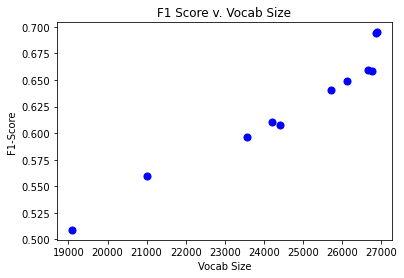

In [178]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    #word based vectorizer
    #build training vocab
    ### STUDENT START ###
    #word based vectorizer
    #build training vocab
    vctr = CountVectorizer()
    train2 = vctr.fit_transform(train_data)
    base_vocab = vctr.get_feature_names()
    #turn base vocab into an array for processing later
    base_vocab_arr = np.array(base_vocab)
    #build dev Vectorizer with trng vocab
    dev_vctr = CountVectorizer(vocabulary=base_vocab)
    dev2 = dev_vctr.fit_transform(dev_data)
    
    #Run base model for results comparison
    LR_base = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", tol = .015)
    LR_base.fit(train2,train_labels)
    pred = LR_base.predict(dev2)
    print("Base Model Vocab Size: "+str(len(base_vocab))+
         " | Base Model F1-Score: "+str(metrics.f1_score(dev_labels,pred,average="weighted")))

    #containers for f1 score, vocab sizes, and reg strength
    f1_scores = []
    vocab_sizes = []
    l1_str = [.0001,.01,.05,.1,.5,1,3,5,10,50,100]
    
    #loop for various l1 strengths
    for c in l1_str:
        #build and train LR with L1 reg
        LR = LogisticRegression(solver="liblinear", C = c, tol=0.015, penalty="l1")
        LR.fit(train2, train_labels)
        #find where coefs are not zero, then sum down cols to find features without coefs across
        #all topics, then use that bool matrix to filter those features out of our vocab
        new_vocab = list(base_vocab_arr[((LR.coef_ != 0)*1).sum(axis=0)==0])
        new_vocab_size = len(new_vocab)
        #add to our container
        vocab_sizes.append(new_vocab_size)
        print("New Vocab Size: "+str(new_vocab_size))

        #use new vocab to build new vectorizer before training a new model
        new_vctr = CountVectorizer(vocabulary=new_vocab)
        train3 = new_vctr.fit_transform(train_data)
        #build dev Vectorizer with new vocab
        dev_vctr2 = CountVectorizer(vocabulary=new_vocab)
        dev3 = dev_vctr2.fit_transform(dev_data)
        #build and train new regression
        LR2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", tol = .015)
        LR2.fit(train3, train_labels)
        #pred using new dev data
        pred = LR2.predict(dev3)
        #assess model and store results
        f1score = metrics.f1_score(dev_labels, pred, average="weighted")
        f1_scores.append(f1score)
        #print results
        print("L1 Reg Strength: "+str(c)+
             " | New Vocab Size: "+str(new_vocab_size)+
             " | F1-Score: "+str(f1score))
    
    #plot results
    fig, ax = plt.subplots()
    ax.scatter(vocab_sizes,f1_scores, s = 50, c = 'blue')
    ax.set_title("F1 Score v. Vocab Size")
    ax.set_xlabel("Vocab Size")
    ax.set_ylabel("F1-Score")
    plt.show()

    ### STUDENT END ###

Q6()

ANSWER: Performance generally improves as vocabulary size increases. 

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [210]:
def Q7():
    ### STUDENT START ###
    #build Countvectorizers
    vctr = CountVectorizer()
    trn = vctr.fit_transform(train_data)
    vocab_base = vctr.get_feature_names()
    dev_v = CountVectorizer(vocabulary=vocab_base)
    dev = dev_v.fit_transform(dev_data)
    
    #build and train base model 
    LR_base = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    LR_base.fit(trn, train_labels)
    
    #score the base model
    print("Base F1 Score: " + str(
    metrics.f1_score(dev_labels, 
                    LR_base.predict(dev),average = "weighted")))
    
    #----#
    
    #build tfidf vectorizers
    tfidf = TfidfVectorizer()
    tf_data = tfidf.fit_transform(train_data)
    vocab = tfidf.get_feature_names()
    dev_tfd = TfidfVectorizer(vocabulary=vocab)
    dev2 = dev_tfd.fit_transform(dev_data)
    
    #build and train model 
    LR = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    LR.fit(tf_data, train_labels)
    
    #score the tfd model
    print("TFDIDF F1 Score: " + str(
    metrics.f1_score(dev_labels, 
                    LR.predict(dev2),average = "weighted")))
    
    #find predicted probs
    pred_probs = LR.predict_proba(dev2)  
    pred = LR.predict(dev2)
    
    #find max prob for each document
    max_probs = np.amax(pred_probs,axis = 1)
    
    #create container array for corr lbl probs
    corr_lbl_probs = np.ndarray((dev_labels.shape[0]))
    
    #now find the prob for the correct label of each doc
    #set up for loop to iterate along indices for dev_data and pred_probs
    for i in range(dev_labels.shape[0]):
        #find the right label for each dev doc, pull the prob associated with that label 
        #from pred probs, and add it to the container array
        corr_lbl_probs[i] = pred_probs[i][dev_labels[i]]
    
    #now divide max probs array and corr lbl array to find r ratio
    r_ratio = max_probs/corr_lbl_probs
    
    #use argSort to find the indices of the three largest R ratios and use those indices
    #to pull pred and correct labels
    print("\nThe three documents in Dev Data with the highest R-Ratios are as follows: ")
    for j in np.argsort(r_ratio)[-3:]:
        print("\nDocument "+str(j) + " | Ratio: "+ str(r_ratio[j])
             +"\nPredicted Label: "+ newsgroups_train.target_names[pred[j]]
              +" | Correct Label: "+ newsgroups_train.target_names[dev_labels[j]]
              + "\nDocument Text: "+dev_data[j])
        
    
    ### STUDENT END ###

Q7()

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Base F1 Score: 0.6828092853619281


/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TFDIDF F1 Score: 0.756815935313557

The three documents in Dev Data with the highest R-Ratios are as follows: 

Document 665 | Ratio: 358.7605280369596
Predicted Label: comp.graphics | Correct Label: talk.religion.misc
Document Text: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Document 607 | Ratio: 386.26048406422893
Predicted Label: talk.religion.misc | Correct Label: alt.atheism
Document Text: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Document 215 | Ratio: 1010.9213840696098
Predicted Label: comp.graphics | Correct Label: talk.religion.misc
Document Text: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in tit

ANSWER: 
<br> 3. The R-Ratio quantifies how wrong the model is when incorrectly labeling a document. The wider the gap between predicted probabilities for the incorrect and correct labels, the larger the ratio, and the more wrong the model was for that particular document.
<br> 4. The model likely puts a significant amount of weight on terms, like FTP, that occur often for a certain type of document (com.graphics). I propose using regularization to diminish the weight and potentially reduce the R-Ratios in question.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [215]:
#build tfidf vectorizers
tfidf = TfidfVectorizer()
tf_data = tfidf.fit_transform(train_data)
vocab = tfidf.get_feature_names()
dev_tfd = TfidfVectorizer(vocabulary=vocab)
dev2 = dev_tfd.fit_transform(dev_data)

#build and train model 
LR = LogisticRegression(C=10, solver="liblinear", multi_class="auto")
LR.fit(tf_data, train_labels)

#score the tfd model
print("TFDIDF F1 Score: " + str(
metrics.f1_score(dev_labels, 
                LR.predict(dev2),average = "weighted")))

#find predicted probs
pred_probs = LR.predict_proba(dev2)  
pred = LR.predict(dev2)

#find max prob for each document
max_probs = np.amax(pred_probs,axis = 1)

#create container array for corr lbl probs
corr_lbl_probs = np.ndarray((dev_labels.shape[0]))

#now find the prob for the correct label of each doc
#set up for loop to iterate along indices for dev_data and pred_probs
for i in range(dev_labels.shape[0]):
    #find the right label for each dev doc, pull the prob associated with that label 
    #from pred probs, and add it to the container array
    corr_lbl_probs[i] = pred_probs[i][dev_labels[i]]

#now divide max probs array and corr lbl array to find r ratio
r_ratio = max_probs/corr_lbl_probs

#use argSort to find the indices of the three largest R ratios and use those indices
#to pull pred and correct labels
print("\nThe three documents in Dev Data with the highest R-Ratios are as follows: ")
for j in np.argsort(r_ratio)[-3:]:
    print("\nDocument "+str(j) + " | Ratio: "+ str(r_ratio[j])
         +"\nPredicted Label: "+ newsgroups_train.target_names[pred[j]]
          +" | Correct Label: "+ newsgroups_train.target_names[dev_labels[j]]
          + "\nDocument Text: "+dev_data[j])

/Users/brendan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TFDIDF F1 Score: 0.7580995674046379

The three documents in Dev Data with the highest R-Ratios are as follows: 

Document 607 | Ratio: 27.027175285931737
Predicted Label: talk.religion.misc | Correct Label: alt.atheism
Document Text: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Document 665 | Ratio: 43.60685412663669
Predicted Label: comp.graphics | Correct Label: talk.religion.misc
Document Text: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Document 215 | Ratio: 44.3329877596624
Predicted Label: comp.graphics | Correct Label: talk.religion.misc
Document Text: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in titl